In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#sns.set(color_codes=True)
from IPython.display import clear_output

## Data Preparation


###  loading the bikes dataset

In [2]:
# Using pandas read_excel function since the file is an excel file
df = pd.read_excel("biking_dataset.xlsx")
#  To simplify accessing the column names in the analysis, cleaning the name of the columns to keep  every character as lower case and keeping only alpha numeric characters
print(df.columns)
df.columns = [''.join(ch.lower() for ch in column if ch.isalnum()) for column in df.columns]
print(df.columns)

Index(['City', 'Weather Condition', 'Rider Age', 'Bike Model',
       'Ride Duration (min)', 'Distance Covered (km)', 'Rider Satisfaction',
       'Bike Rental Cost ($)'],
      dtype='object')
Index(['city', 'weathercondition', 'riderage', 'bikemodel', 'ridedurationmin',
       'distancecoveredkm', 'ridersatisfaction', 'bikerentalcost'],
      dtype='object')


### Size of the dataset

In [3]:
# Checking the number rows and columns  of the dataset 
# the df.shape shows the number of rows and columns
# There are 900 rows and 8 columns
df.shape

(900, 8)

### Characterizing columns

In [4]:
#
df.dtypes

city                  object
weathercondition      object
riderage             float64
bikemodel             object
ridedurationmin      float64
distancecoveredkm    float64
ridersatisfaction     object
bikerentalcost       float64
dtype: object

| Column Name            | Data Type   | Description                                                                                     |
|------------------------|-------------|-------------------------------------------------------------------------------------------------|
| City                   | Categorical | The main city where the bike ride takes place. Possible values: "New York", "San Francisco", "Chicago", "London", "Berlin". |
| Weather Condition      | Categorical | Weather conditions during the bike ride. Possible values: "Sunny", "Rainy", "Cloudy", "Snowy".  |
| Rider Age              | Numeric     | The age of the rider (in years). Range: 18 to 60.                                               |
| Bike Model             | Categorical | The type of bike used during the ride. Possible values: "Standard", "Electric", "Mountain".      |
| Ride Duration (min)    | Numeric     | The duration of the ride in minutes. Range: 5 to 120 minutes.                                   |
| Distance Covered (km)  | Numeric     | The total distance covered during the bike ride (in kilometers). Range: 0.5 to 40 km.           |
| Rider Satisfaction     | Categorical | The satisfaction level of the rider after the ride. Possible values: "Low", "Medium", "High". This is the target variable for classification tasks. |
| Bike Rental Cost ($)   | Numeric     | The total cost of the bike rental in USD. The value is influenced by factors such as ride duration and bike model. This is the target variable for regression tasks. |

In [5]:
# Splitting the columns as numerical and categorical since some plots and analysis are different between those two groups
# Pandas allow us to select columns by the "dtype" of the column
numeric_columns = df.select_dtypes(include='number').columns
categorical_columns = df.select_dtypes(include='object').columns
print(numeric_columns)
print(categorical_columns)

Index(['riderage', 'ridedurationmin', 'distancecoveredkm', 'bikerentalcost'], dtype='object')
Index(['city', 'weathercondition', 'bikemodel', 'ridersatisfaction'], dtype='object')


### Analysing missing values

In [6]:
# I created a datatframe to summary the missing data per column 
# Reporting missing values per column
# We notice around 1% missing values per column
missing_values = df.isnull().sum()
percentage_mssing_values = (missing_values/len(df))*100
missing_values_df = pd.DataFrame({'Column Name': missing_values.index,
                                  'Missing Values': missing_values.values,
                                  'Percentage Missing Values': percentage_mssing_values.values,
                                 })
missing_values_df

,Column Name,Missing Values,Percentage Missing Values
0,city,10,1.111111
1,weathercondition,11,1.222222
2,riderage,15,1.666667
3,bikemodel,10,1.111111
4,ridedurationmin,13,1.444444
5,distancecoveredkm,13,1.444444
6,ridersatisfaction,11,1.222222
7,bikerentalcost,9,1.000000


In [7]:
# Checking for duplicated rows
df.duplicated().sum()

0

In [8]:
# Do we have specific columns with a lot of missing data ?
# I wanted to know for the rows which have (0, 1 ,2) missing data how much is for a specific column ? 
# Calculate the number of missing values ( we specificy the axis to do it by each row )
# We create a new column Missing Count with this count per row
# and group rows by this count ( we can then for loop to each group and do statistics)

df['Missing Count'] = df.isnull().sum(axis=1)
# Group rows by the number of missing values
grouped = df.groupby('Missing Count')
# Iterate through the groups
for missing_count, group in grouped:
    n_rows = len(group)
    percent = (n_rows/len(df))*100
    print(f"{n_rows} rows ({percent} %) missing {missing_count} value")
    missing_values = group.isnull().sum()
    percentage_mssing_values = (missing_values/len(group))*100
    missing_values_df = pd.DataFrame({'Column Name': missing_values.index,
                                      'Missing Values': missing_values.values,
                                      'Percentage Missing Values': percentage_mssing_values.values,
                                     })
    print(missing_values_df)
    print("\n")
del df['Missing Count']

853 rows (94.77777777777779 %) missing 0 value
         Column Name  Missing Values  Percentage Missing Values
0               city               0                        0.0
1   weathercondition               0                        0.0
2           riderage               0                        0.0
3          bikemodel               0                        0.0
4    ridedurationmin               0                        0.0
5  distancecoveredkm               0                        0.0
6  ridersatisfaction               0                        0.0
7     bikerentalcost               0                        0.0
8      Missing Count               0                        0.0


3 rows (0.33333333333333337 %) missing 1 value
         Column Name  Missing Values  Percentage Missing Values
0               city               0                   0.000000
1   weathercondition               0                   0.000000
2           riderage               0                   0.000000
3       

In [9]:
# dropping any missing value
# 5% of rows are missing at least one value
# there are 42 rows with missing 2 values and they are spread across multiple columns
# The cost of removing 5% of rows seems reasonable compared to the effort of deciding how to fill the missing values for many different situtations
df_any_missing_value = df.dropna()
print(df.shape, df_any_missing_value.shape,47/900)

(900, 8) (853, 8) 0.052222222222222225


In [10]:
cleaned_df = df_any_missing_value

In [11]:
# describing numerical variables
print("\tSummary Statistics of Numerical Variables")
cleaned_df.describe()

	Summary Statistics of Numerical Variables


,riderage,ridedurationmin,distancecoveredkm,bikerentalcost
count,853.000000,853.00000,853.000000,853.000000
mean,39.262603,61.76905,20.152016,26.564033
std,12.332311,34.18023,11.226650,9.501788
min,18.000000,5.00000,0.510000,7.330000
25%,29.000000,32.00000,10.750000,19.110000
50%,39.000000,62.00000,19.990000,27.080000
75%,50.000000,92.00000,29.200000,34.010000
max,60.000000,120.00000,39.870000,48.380000


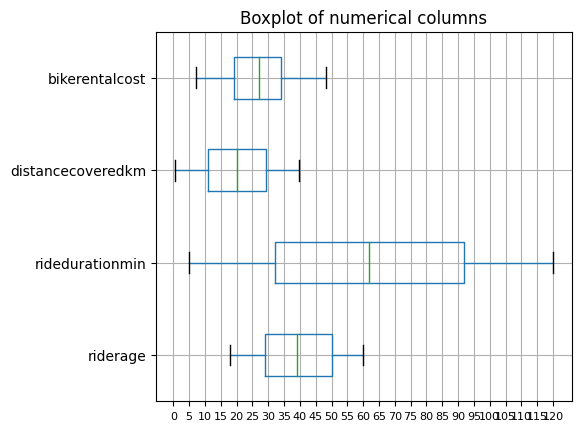

In [12]:
# using this example : https://stackoverflow.com/questions/18500011/horizontal-box-plots-in-matplotlib-pandas
# The boxplot helps us visualiz the distribution of numerical columns
# together with the summary table it gives a general view of each column
df[numeric_columns].boxplot(vert=False)
plt.subplots_adjust(left=0.25)
plt.xticks(range(0, int(df[numeric_columns].max().max()) + 1, 5),fontsize=8)
plt.title("Boxplot of numerical columns")
plt.show()


In [13]:
# describing categorical variables
# This table gives us the intuition most categorical variables have a few categories only
# and together with the bar plot it shows that those categories are reasonably uniform
cleaned_df.describe(include='object')

,city,weathercondition,bikemodel,ridersatisfaction
count,853,853,853,853
unique,6,4,4,3
top,London,Rainy,Electric,High
freq,183,238,285,307


#### City is uniform in frequency except for dublin which has very few examples
#### Weather condition is pretty uniform as well, most frequent is rainy days
#### Bike model is uniform with only one example of "manual"
#### riderstisfaction is uniform, slightly more people are High satistifeid vs medium vs low

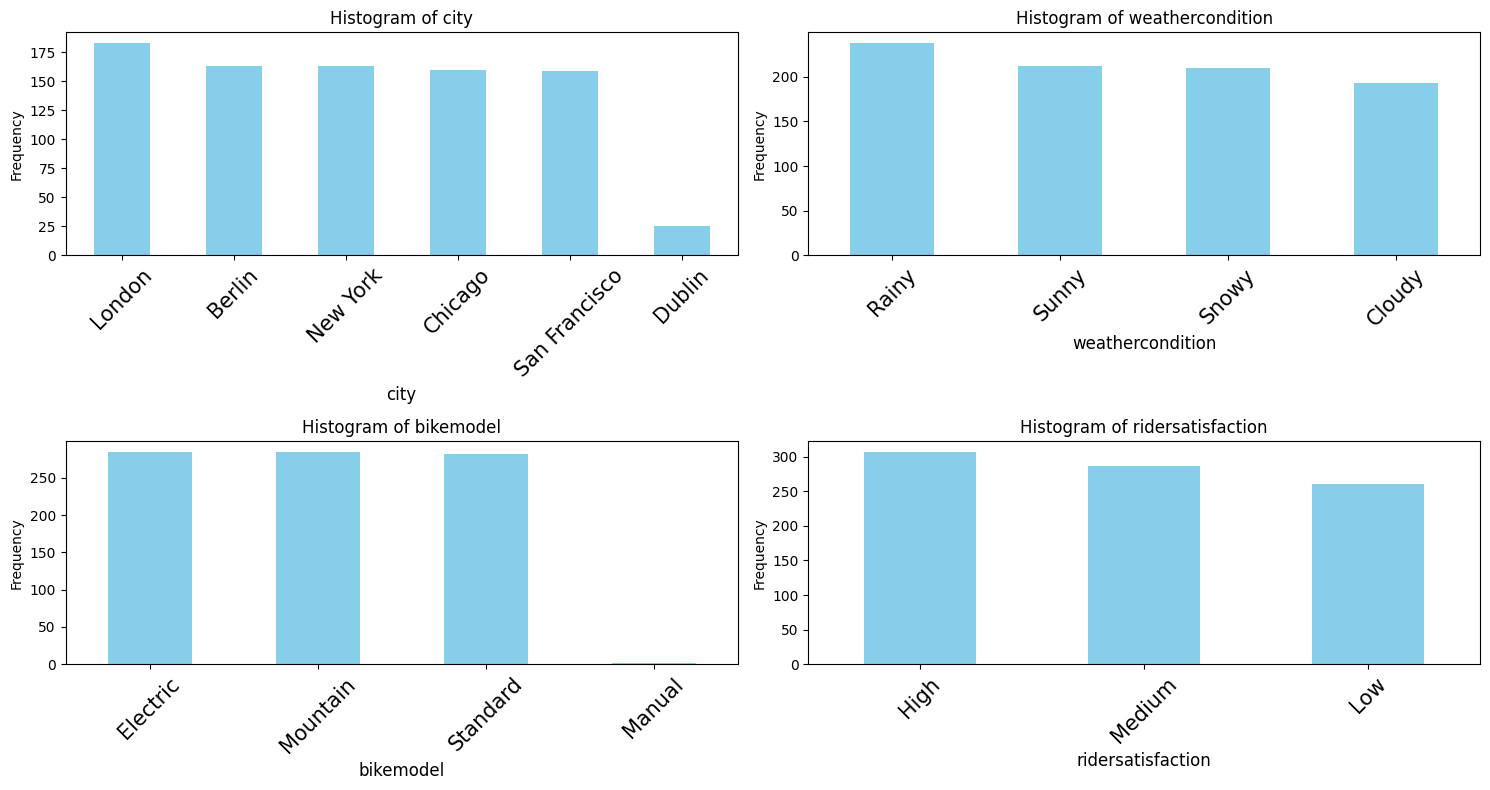

In [14]:
# creating a subplot with 4 (2x2) plots to show the distribution of categories in dataset
# then for each categorical column plot the bar plot
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    # Plot the bar chart on the corresponding subplot
    cleaned_df[column].value_counts().plot(kind='bar', color='skyblue', ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column,fontsize=12)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45,labelsize=15)

plt.tight_layout()
plt.show()

In [15]:
# Droping the only row which contains bikemodel == "manual"
# using example https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value
cleaned_df = cleaned_df[ cleaned_df["bikemodel"] != "Manual" ]

In [ ]:
# Bivariate analysis of numerical columns
# Here we plot pairplots for each pair of numerical columns 
# with the goal of understandaing the relationship between variables
# there is a clear linear relationship bike rental cost and duration (which is intuitive)
# but all other numerical variables does not have an inutitive relationship
print("numerical columns scatterplot (pairplot)")

In [ ]:
sns.pairplot

numerical columns scatterplot (pairplot)


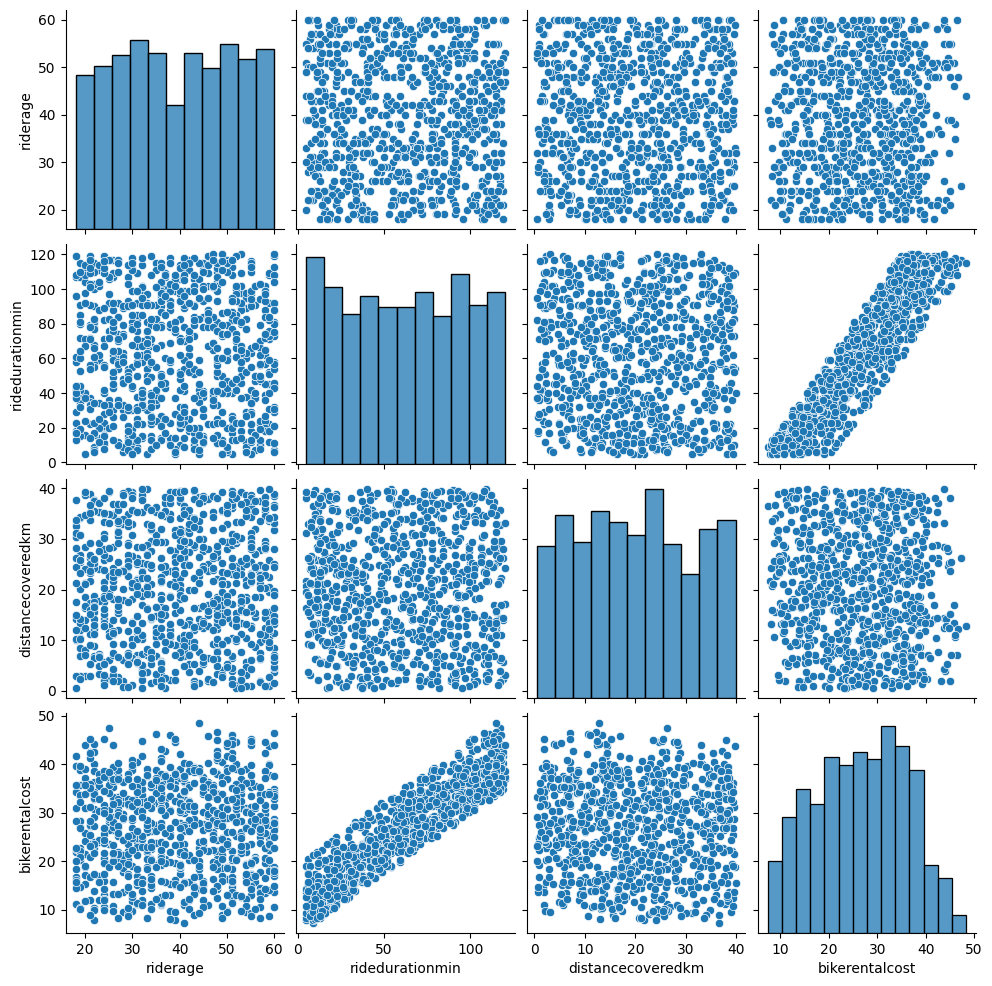

In [ ]:
(cleaned_df[numeric_columns])

## Machine Learning


## Ideas to investigate
#### Are people overall satistified ?
#### People satisfaction is almost even between low, medium and high
#### What are the most profitables regions ?
#### What are the regions with higher and lower satisfcation ?
#### Do satisfied people pay more ? less ?


In [16]:
targets=['ridersatisfaction','bikerentalcost']
for col in targets:
    print(df[col].value_counts())


ridersatisfaction
High      319
Medium    299
Low       271
Name: count, dtype: int64
bikerentalcost
32.75    3
23.85    3
15.67    3
26.90    3
31.43    3
        ..
11.97    1
21.81    1
22.16    1
11.44    1
13.02    1
Name: count, Length: 786, dtype: int64


In [17]:
df['bikerentalcost'].describe()

count    891.000000
mean      26.581470
std        9.438224
min        7.330000
25%       19.210000
50%       27.040000
75%       33.955000
max       48.380000
Name: bikerentalcost, dtype: float64

<Axes: >

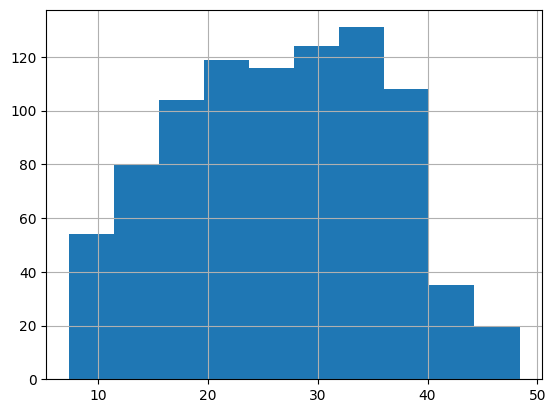

In [18]:
df['bikerentalcost'].hist()

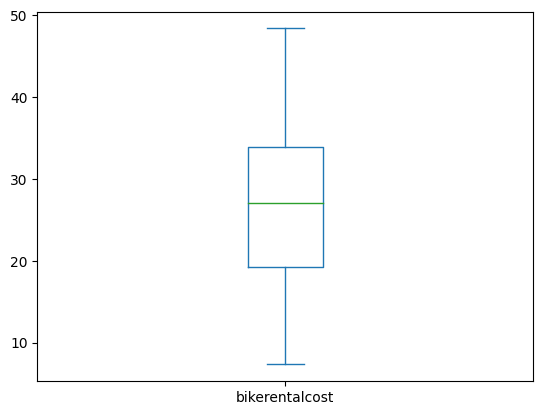

In [19]:

ax = df[targets].plot.box()

<Axes: xlabel='ridersatisfaction'>

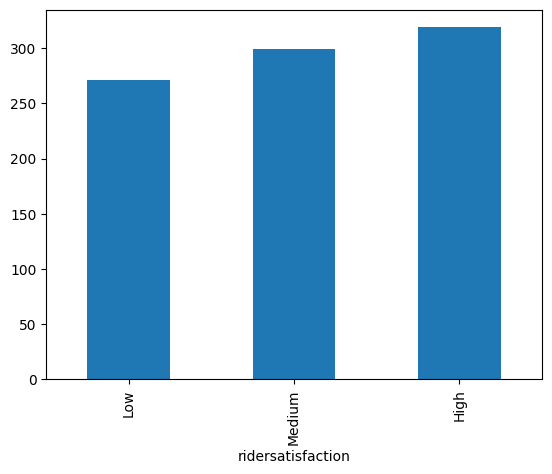

In [20]:
df['ridersatisfaction'].value_counts()[['Low','Medium','High']].plot(kind='bar')

In [21]:
df['ridersatisfaction'].value_counts()

ridersatisfaction
High      319
Medium    299
Low       271
Name: count, dtype: int64

## References

https://stackoverflow.com/questions/18500011/horizontal-box-plots-in-matplotlib-pandas

https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value